## Kibot.com 에서 선물일봉 데이터 만들기
 * KibotAPI 이용
 * 단순연결선물 데이터 제공

> 추후 월물별 데이터를 재가공하여 Ajusted continuous futures 데이터 가공계획

In [1]:
import sys
sys.path.append('..')
import requests
import csv
import h5py
import os
import numpy as np

In [2]:
from tools.instruments import instruments

In [3]:
DATADIR = os.path.join('.','../data/kibot','quotes.hdf')

### 1. Kibot에서 다운 가능한 종목 코드 불러오기 
* 불러온 종목코드는 symbols[] 에 저장

In [4]:
symbols = instruments.getlist('kibot')

### 2. Kibot.com 서버에서 데이터 다운로드

In [5]:
LoginURL = "http://api.kibot.com?action=login&user=guest&password=guest"
DataRequestURL = "http://api.kibot.com"
LogoutURL = "http://api.kibot.com?action=logout"

In [6]:
#  연결선물일봉 데이터 다운용 쿼리
query={
    'action': 'history',
    'symbol': '',
    'interval': 'daily',
    'type': 'futures',
    'period': '99999',
    'timezone': 'utc'
}

In [7]:
file = h5py.File(DATADIR, 'w')

In [8]:
dtypes= np.dtype([('date', 'i'), ('open', 'f'),('high','f'), ('low','f'), ('close','f'), ('volume', 'i'), ('open_interest','i')])

In [9]:
# http requests session 연결 후 종목별 다운로드
print("서버 접속 시작")
with requests.Session() as session:
    res = session.get(LoginURL)
    if res.status_code != 200:
        print(res.text)
        session.close()
        
    for symbol in symbols:
        print(f"{symbol} 다운로드...")
        query['symbol'] = symbol
        ret = session.get("http://api.kibot.com", params=query)
        
        if ret.status_code != 200:
            print(ret.text)
            session.close()
        
        datalist = []    
        for line in ret.text.splitlines():
            quote = line.split(',')
            date = quote[0].split('/')
            date=np.datetime64('-'.join([date[2],date[0],date[1]])).astype('M8[D]').astype('i')
            datalist.append((date,quote[1],quote[2],quote[3],quote[4],quote[5],'0'))
        file.create_dataset(instruments.filter(kibot=symbol)[0].symbol, data=np.array(datalist, dtypes))
file.close()
print("다운로드 완료")

서버 접속 시작
AD 다운로드...
BO 다운로드...
BP 다운로드...
CD 다운로드...
CL 다운로드...
EU 다운로드...
ED 다운로드...
ES 다운로드...
FF 다운로드...
FV 다운로드...
GC 다운로드...
HG 다운로드...
JY 다운로드...
LB 다운로드...
LE 다운로드...
HE 다운로드...
EMD 다운로드...
NE 다운로드...
NG 다운로드...
NKD 다운로드...
NQ 다운로드...
O 다운로드...
PA 다운로드...
PL 다운로드...
RR 다운로드...
RTY 다운로드...
S 다운로드...
SF 다운로드...
SI 다운로드...
SM 다운로드...
TU 다운로드...
TY 다운로드...
US 다운로드...
VX 다운로드...
W 다운로드...
YM 다운로드...
다운로드 완료


In [19]:
file.close()

### 3. 데이터 검증

In [10]:
import pandas as pd

In [11]:
file = h5py.File(DATADIR, 'r')

In [12]:
data = file['LE'][:]

In [13]:
data

array([(11764,  72.075,  72.3  ,  71.825,  72.15 ,    10, 0),
       (11765,  71.95 ,  72.425,  71.225,  71.225,    10, 0),
       (11766,  70.85 ,  71.6  ,  70.75 ,  70.95 ,    10, 0), ...,
       (19088, 133.5  , 134.625, 132.475, 134.225, 22671, 0),
       (19089, 134.375, 134.975, 134.025, 134.1  , 20005, 0),
       (19090, 134.05 , 135.15 , 133.375, 133.825, 18948, 0)],
      dtype=[('date', '<i4'), ('open', '<f4'), ('high', '<f4'), ('low', '<f4'), ('close', '<f4'), ('volume', '<i4'), ('open_interest', '<i4')])

In [14]:
df = pd.DataFrame(data)
df['date'] = df['date'].astype('M8[D]')
df.set_index('date', inplace=True)

In [15]:
df

,open,high,low,close,volume,open_interest
date,,,,,,
2002-03-18,72.074997,72.300003,71.824997,72.150002,10,0
2002-03-19,71.949997,72.425003,71.224998,71.224998,10,0
2002-03-20,70.849998,71.599998,70.750000,70.949997,10,0
2002-03-21,70.525002,70.525002,70.525002,70.525002,10,0
2002-03-22,69.775002,69.775002,69.775002,69.775002,10,0
...,...,...,...,...,...,...
2022-04-04,135.399994,136.350006,133.875000,134.925003,23648,0
2022-04-05,135.199997,135.250000,133.100006,133.324997,24475,0
2022-04-06,133.500000,134.625000,132.475006,134.225006,22671,0


In [16]:
from tools import ohlc_chart, view

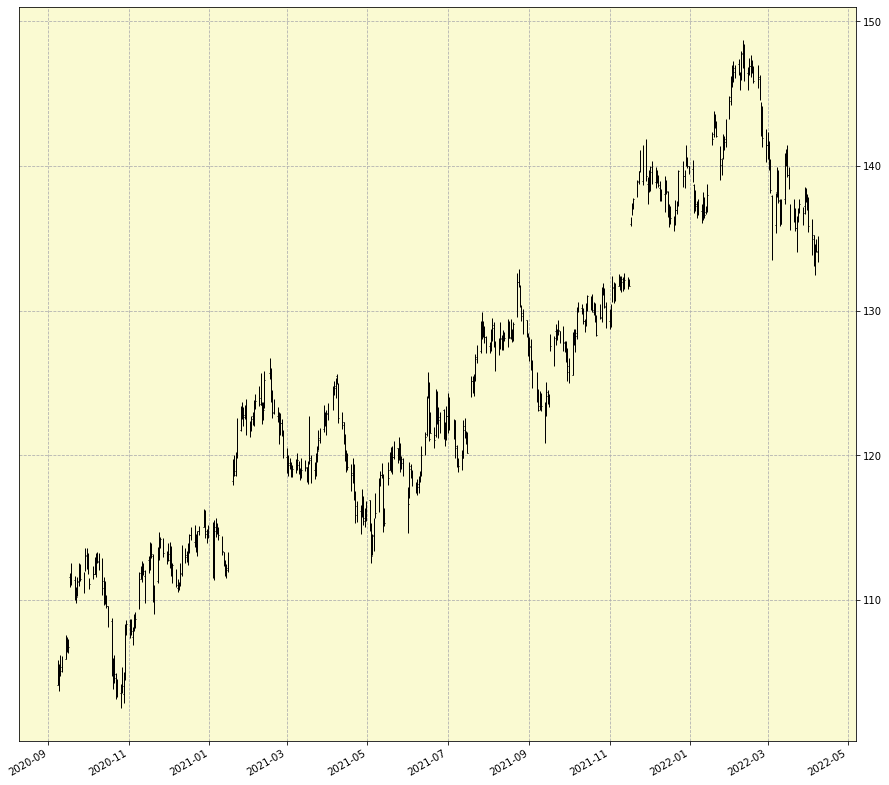

In [17]:
view(df['2020-09-08':], period='day', size=(15,15),)